In [1]:
from discretizer import discretizer
from client import client
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from server import server_twosample_U, server_twosample_chi
from data_generator import data_generator
import time

In [37]:
device

device(type='cpu')

In [48]:
p = torch.tensor([0.3]).to(device)
m = torch.distributions.bernoulli.Bernoulli(p)
a=m.sample((2,5)).view(2,5)
a

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])

In [51]:
a.eq(1).mul(-2)

tensor([[ 0,  0,  0, -2,  0],
        [ 0,  0,  0, -2,  0]])

In [3]:
gen = data_generator(device)

In [51]:
p, p_priv = gen._generate_power_law_p_private(10,2.1, 0.5)

<BarContainer object of 10 artists>

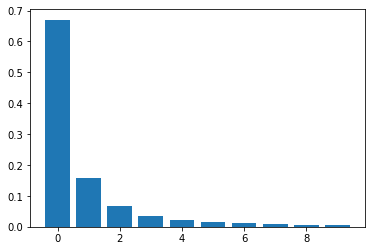

In [52]:
plt.bar(range(10), p.cpu())

<BarContainer object of 10 artists>

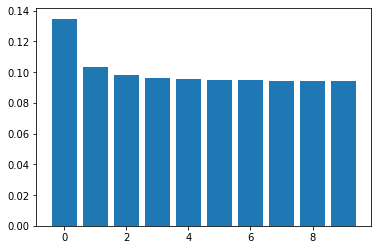

In [53]:
plt.bar(range(10), p_priv.cpu())

In [2]:
t = time.time()

server_now = server_twosample_U(device)
data_gen = data_generator(device)
alphabet_size = 1000
beta = 0.5
privacy_level = 1
n_test = 1
n_permutation = 99
significance_level = 0.05
sample_size = 100000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_LapU(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, n_permutation)
    
    
elapsed = time.time() - t
elapsed

16.566758632659912

In [9]:
(data_y==0).sum()

tensor(1621, device='cuda:0')

In [15]:
torch.tensor([1,2,4]).bincount(minlength=6)

tensor([0, 1, 1, 0, 1, 0])

# performance of GenRR 

In [25]:
t = time.time()

server_now = server_twosample_chi(device)
data_gen = data_generator(device)
alphabet_size = 3000
beta = 2.5
privacy_level = 0.01
n_test = 100
sample_size = 10000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_genRR(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, alphabet_size)
    
    
elapsed = time.time() - t
elapsed

131.28636121749878

In [24]:
(test_result < 0.7).sum()/n_test 

tensor(0.7100, device='cuda:0')

In [6]:
data_y_priv.dtype

torch.int64

# testing the discretizer

In [2]:
data_conti = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0.6],
    [0, 0, 0.6, 0],
    [0, 0, 0.6, 0.6],
    [0, 0.6, 0, 0],
    [0, 0.6, 0, 0.6],
    [0, 0.6, 0.6, 0],
    [0, 0.6, 0.6, 0.6],   
    [0.6, 0, 0, 0],
    [0.6, 0, 0, 0.6],
    [0.6, 0, 0.6, 0],
    [0.6, 0, 0.6, 0.6],
    [0.6, 0.6, 0, 0],
    [0.6, 0.6, 0, 0.6],
    [0.6, 0.6, 0.6, 0],
    [0.6, 0.6, 0.6, 0.6],
])
dsc = discretizer(device)
data_disc, n_category = dsc.transform(data_conti, 2)
data_disc

LDPclient = client(device)
LDPclient.load_data_disc(data_disc, data_disc, n_category)

# testing the LapU for discrete data

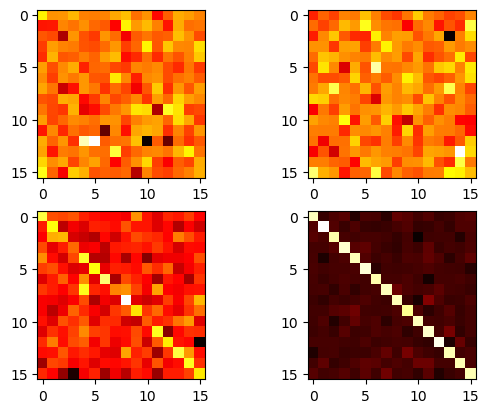

In [55]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_LapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_LapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_LapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_LapU(100)[1], cmap = 'hot', interpolation = 'nearest')

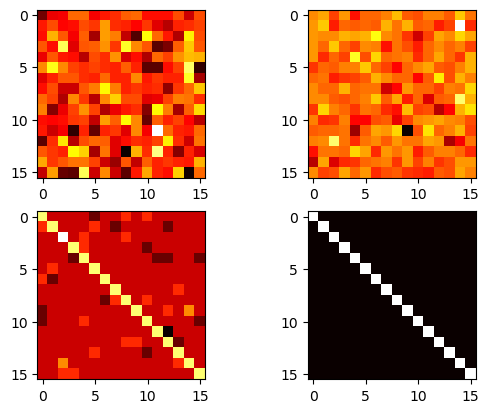

In [58]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')

C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\2887809965.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(0.5)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\2887809965.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(1)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\2887809965.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(10)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\2887809

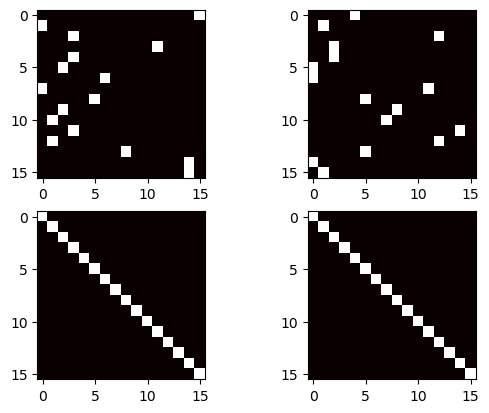

In [3]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(0.5)[1]),
        16
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[0,1].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(1)[1]),
        16
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[1,0].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(10)[1]),
        16
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[1,1].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(50)[1]),
        16
        ),
    cmap = 'hot', interpolation = 'nearest'
)

C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[0,0].imshow(torch.tensor(LDPclient.release_bitFlip(0.5)[1]),cmap = 'hot', interpolation = 'nearest')
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[0,1].imshow(torch.tensor(LDPclient.release_bitFlip(1)[1]),cmap = 'hot', interpolation = 'nearest')
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

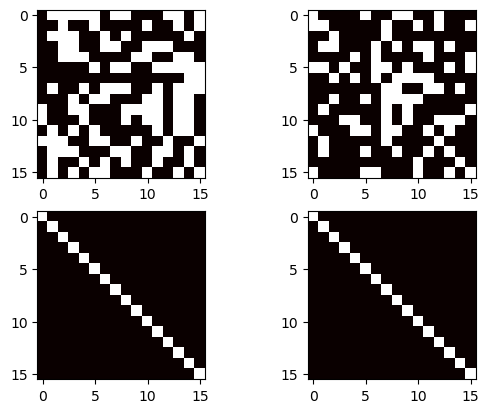

In [9]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(torch.tensor(LDPclient.release_bitFlip(0.5)[1]),cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(torch.tensor(LDPclient.release_bitFlip(1)[1]),cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(torch.tensor(LDPclient.release_bitFlip(10)[1]),cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(torch.tensor(LDPclient.release_bitFlip(10)[1]),cmap = 'hot', interpolation = 'nearest')


In [65]:
LDPclient.release_genRR(0.5)[1]

tensor([ 8,  3,  1,  8,  4, 13,  3, 12,  2,  8, 10, 15, 14,  1, 15, 11])

In [ ]:
axs[0,1].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(1), 16)), cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(10), 16)), cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(100), 16)), cmap = 'hot', interpolation = 'nearest')

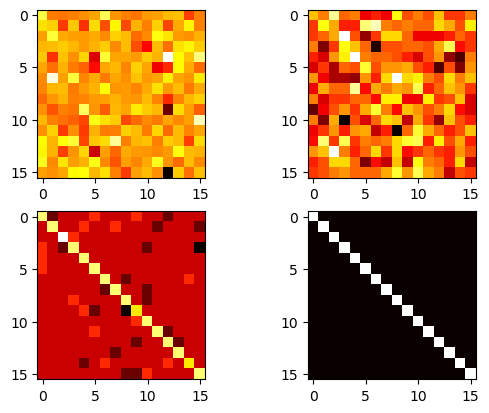

In [9]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')

